In [ ]:
# CPU‑only, < 1hour

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%pip -q install "numpy<2.0" "batman-package==2.4.9" "pandas<2.0" "matplotlib<4.0" "astropy<6.0" "scipy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 76.3 MB/s eta 0:00:00


In [1]:
import os, sys
print("Installed numpy<2 and batman-package; restarting the runtime to load them correctly...")
#os.kill(os.getpid(), 9)  # <-- forces a clean restart# --- 0. Imports, paths, and utility functions ---
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

Installed numpy<2 and batman-package; restarting the runtime to load them correctly...


In [2]:
# Re-run setup without requiring astropy at import time

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Attempt optional imports and set flags
try:
    from astropy.io import fits  # for FITS I/O (optional)
    ASTROPY_AVAILABLE = True
except Exception:
    ASTROPY_AVAILABLE = False

try:
    from scipy.optimize import curve_fit
    from scipy.stats import f as f_dist
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Paths
lc_paths = [
    "/content/drive/MyDrive/AutoTTV/tess2018234235059-s0002-0000000402026209-0121-s_lc.fits",
    "/content/drive/MyDrive/AutoTTV/tess2020212050318-s0028-0000000402026209-0190-s_lc.fits",
    "/content/drive/MyDrive/AutoTTV/tess2020238165205-s0029-0000000402026209-0193-s_lc.fits",
    "/content/drive/MyDrive/AutoTTV/tess2023237165326-s0069-0000000402026209-0264-s_lc.fits",
]

def check_files(paths):
    rows = []
    for p in paths:
        ok = os.path.exists(p)
        rows.append({
            "file": os.path.basename(p),
            "exists": ok,
            "size_bytes": os.path.getsize(p) if ok else 0
        })
    return pd.DataFrame(rows)

file_check_df = check_files(lc_paths)
file_check_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


file  exists  size_bytes
0  tess2018234235059-s0002-0000000402026209-0121-...    True     2004480
1  tess2020212050318-s0028-0000000402026209-0190-...    True     1848960
2  tess2020238165205-s0029-0000000402026209-0193-...    True     1915200
3  tess2023237165326-s0069-0000000402026209-0264-...    True     1886400

In [4]:
# --- 2) Data Loading ---
print(f"Astropy available: {ASTROPY_AVAILABLE}")
print(f"SciPy available:   {SCIPY_AVAILABLE}")

def read_tess_lc(path):
    """
    Read a TESS lightcurve FITS file and return a DataFrame with:
    time_bjd (BJD_TDB), flux, flux_err, quality, sector (int)
    If astropy is not available, return None.
    """
    if not ASTROPY_AVAILABLE:
        return None, "Astropy not available to read FITS."
    try:
        hdul = fits.open(path, memmap=True)
        hdr = hdul[0].header
        data = hdul[1].data

        # TESS times are in BTJD = BJD_TDB - 2457000
        # Convert to BJD_TDB
        time_bjd = data["TIME"] + 2457000.0

        df = pd.DataFrame({
            "time_bjd": time_bjd,
            "flux": data["PDCSAP_FLUX"],
            "flux_err": data["PDCSAP_FLUX_ERR"],
            "quality": data["QUALITY"]
        })
        try:
            sector = int(hdr.get("SECTOR", -1))
        except Exception:
            sector = -1
        df["sector"] = sector

        hdul.close()
        return df, None
    except Exception as e:
        return None, f"Failed to read {os.path.basename(path)}: {e}"

loaded_lcs = []
load_reports = []
for p in lc_paths:
    df, msg = read_tess_lc(p)
    loaded_lcs.append(df)
    load_reports.append({"file": os.path.basename(p), "status": "ok" if df is not None else "skipped", "note": msg})

pd.DataFrame(load_reports)

Astropy available: True
SciPy available:   True


file status  note
0  tess2018234235059-s0002-0000000402026209-0121-...     ok  None
1  tess2020212050318-s0028-0000000402026209-0190-...     ok  None
2  tess2020238165205-s0029-0000000402026209-0193-...     ok  None
3  tess2023237165326-s0069-0000000402026209-0264-...     ok  None

In [5]:
# --- 0. Imports, paths, and utility functions ---
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits  # for FITS I/O


In [6]:
# Re-run setup without requiring astropy at import time

import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Attempt optional imports and set flags
try:
    from astropy.io import fits  # for FITS I/O (optional)
    ASTROPY_AVAILABLE = True
except Exception:
    ASTROPY_AVAILABLE = False

try:
    from scipy.optimize import curve_fit
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False


In [7]:
## Locate local TESS FITS (start like the attached notebook)
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception:
        pass

# Default paths: try local workspace first (e.g., you uploaded the files),
# then a typical Colab/Drive location used in your attached notebook.
local_candidates = [
    '/mnt/data/tess2018234235059-s0002-0000000402026209-0121-s_lc.fits',
    '/mnt/data/tess2020212050318-s0028-0000000402026209-0190-s_lc.fits',
    '/mnt/data/tess2020238165205-s0029-0000000402026209-0193-s_lc.fits',
    '/mnt/data/tess2023237165326-s0069-0000000402026209-0264-s_lc.fits',
]
drive_candidates = [
    '/content/drive/MyDrive/AutoTTV/tess2018234235059-s0002-0000000402026209-0121-s_lc.fits',
    '/content/drive/MyDrive/AutoTTV/tess2020212050318-s0028-0000000402026209-0190-s_lc.fits',
    '/content/drive/MyDrive/AutoTTV/tess2020238165205-s0029-0000000402026209-0193-s_lc.fits',
    '/content/drive/MyDrive/AutoTTV/tess2023237165326-s0069-0000000402026209-0264-s_lc.fits',
]

lc_paths = []
for p in local_candidates:
    if os.path.exists(p):
        lc_paths.append(p)
if len(lc_paths) < 4:
    for p in drive_candidates:
        if os.path.exists(p):
            lc_paths.append(p)

def check_files(paths):
    rows = []
    for p in paths:
        ok = os.path.exists(p)
        rows.append({
            'file': os.path.basename(p),
            'full_path': p,
            'exists': ok,
            'size_bytes': os.path.getsize(p) if ok else 0,
        })
    return pd.DataFrame(rows)

check_files(lc_paths)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


file  \
0  tess2018234235059-s0002-0000000402026209-0121-...   
1  tess2020212050318-s0028-0000000402026209-0190-...   
2  tess2020238165205-s0029-0000000402026209-0193-...   
3  tess2023237165326-s0069-0000000402026209-0264-...   

                                           full_path  exists  size_bytes  
0  /content/drive/MyDrive/AutoTTV/tess20182342350...    True     2004480  
1  /content/drive/MyDrive/AutoTTV/tess20202120503...    True     1848960  
2  /content/drive/MyDrive/AutoTTV/tess20202381652...    True     1915200  
3  /content/drive/MyDrive/AutoTTV/tess20232371653...    True     1886400

In [8]:
## Read TESS PDCSAP light curves from FITS (astropy.io.fits)
BJDREF = 2457000.0

def read_tess_lc(path):
    """Return a DataFrame with BJD_TDB, PDCSAP flux, errors, and sector."""
    try:
        hdul = fits.open(path, memmap=True)
        hdr0 = hdul[0].header
        hdr1 = hdul[1].header
        data = hdul[1].data

        def col(name):
            return np.array(data[name]).astype(float)

        time = col('TIME') + BJDREF
        flux = col('PDCSAP_FLUX') if 'PDCSAP_FLUX' in data.columns.names else col('SAP_FLUX')
        ferr = col('PDCSAP_FLUX_ERR') if 'PDCSAP_FLUX_ERR' in data.columns.names else (
            col('SAP_FLUX_ERR') if 'SAP_FLUX_ERR' in data.columns.names else np.nan*np.zeros_like(flux))
        qual = data['QUALITY'] if 'QUALITY' in data.columns.names else np.zeros_like(flux, dtype=int)

        good = np.isfinite(time) & np.isfinite(flux) & (flux>0) & (qual==0)
        if not np.all(np.isfinite(ferr)):
            ferr = np.where(np.isfinite(ferr), ferr, np.nanmedian(flux[good])*1e-4)
        good &= np.isfinite(ferr) & (ferr>0)

        df = pd.DataFrame({
            'BJD_TDB': time[good],
            'flux': flux[good],
            'ferr': ferr[good],
        }).sort_values('BJD_TDB').reset_index(drop=True)

        try:
            sector = int(hdr0.get('SECTOR', hdr1.get('SECTOR', -1)))
        except Exception:
            sector = -1
        df['sector'] = f"s{sector:04d}" if sector>=0 else 's----'
        hdul.close()
        return df, None
    except Exception as e:
        return None, f'Failed to read {os.path.basename(path)}: {e}'

loaded_lcs, load_reports = [], []
for p in lc_paths:
    df, msg = read_tess_lc(p)
    loaded_lcs.append(df)
    load_reports.append({'file': os.path.basename(p), 'status': 'ok' if df is not None else 'skipped', 'note': msg})
pd.DataFrame(load_reports)


file status  note
0  tess2018234235059-s0002-0000000402026209-0121-...     ok  None
1  tess2020212050318-s0028-0000000402026209-0190-...     ok  None
2  tess2020238165205-s0029-0000000402026209-0193-...     ok  None
3  tess2023237165326-s0069-0000000402026209-0264-...     ok  None

In [9]:
import numpy as np
from scipy.optimize import curve_fit
import batman

def make_batman_model(tt, t0, a0, a1, theta):
    """
    Build a batman transit model using fixed shape parameters (theta)
    but variable t0 (mid-transit), a0 (baseline offset), a1 (linear slope).

    Parameters
    ----------
    tt : array
        Times (BJD_TDB).
    t0 : float
        Mid-transit time to test.
    a0 : float
        Baseline offset.
    a1 : float
        Linear trend slope.
    theta : dict
        Dictionary with transit parameters: {period, rp, a, inc, ecc, w, u, limb_dark}.
    """
    params = batman.TransitParams()
    params.t0   = t0
    params.per  = theta["per"]
    params.rp   = theta["rp"]
    params.a    = theta["a"]
    params.inc  = theta["inc"]
    params.ecc  = theta.get("ecc", 0.0)
    params.w    = theta.get("w", 90.0)
    params.u    = theta["u"]
    params.limb_dark = theta["limb_dark"]

    m = batman.TransitModel(params, tt)
    flux = m.light_curve(params)
    return a0 + a1 * (tt - np.mean(tt)) + flux


def t0_with_theta(tt, ff, ee, t_pred, theta):
    """
    Refit the mid-transit time T0 for a single transit window,
    holding all morphology parameters fixed to theta.

    Parameters
    ----------
    tt : array
        Time stamps (BJD_TDB).
    ff : array
        Flux measurements.
    ee : array
        Flux uncertainties.
    t_pred : float
        Predicted transit center from ephemeris (used as initial guess).
    theta : dict
        Morphology parameters (period, rp, a, inc, ecc, w, u, limb_dark).

    Returns
    -------
    t0_fit : float
        Best-fit mid-transit time.
    t0_err : float
        1σ uncertainty on mid-transit time.
    popt : array
        Best-fit parameters [t0, a0, a1].
    pcov : 2D array
        Covariance matrix.
    """
    def model_for_fit(tt, t0, a0, a1):
        return make_batman_model(tt, t0, a0, a1, theta)

    # initial guesses
    guess = [t_pred, 0.0, 0.0]

    popt, pcov = curve_fit(model_for_fit, tt, ff, p0=guess, sigma=ee, absolute_sigma=True, maxfev=2000)
    t0_fit = popt[0]
    t0_err = np.sqrt(np.diag(pcov))[0] if pcov is not None else np.nan
    return t0_fit, t0_err, popt, pcov


In [10]:
import numpy as np

# --- utilities to poke theta dicts safely ---
def _theta_copy(theta):
    new = dict(theta)
    # copy u list to avoid in-place edits
    if "u" in new and isinstance(new["u"], (list, tuple, np.ndarray)):
        new["u"] = list(new["u"])
    return new

def _set_theta_param(theta, name, value):
    """Support names like 'rp', 'a', 'inc', 'ecc', 'w', 'per', 'u0', 'u1', ..."""
    if name.startswith("u"):
        idx = int(name[1:])
        theta["u"][idx] = value
    else:
        theta[name] = value

def _get_theta_param(theta, name):
    if name.startswith("u"):
        idx = int(name[1:])
        return float(theta["u"][idx])
    return float(theta[name])

# ---- finite-difference Jacobian of T0 wrt morphology parameters θ ----
def t0_fd_jacobian(tt, ff, ee, t_pred, theta_hat, theta_names, eps_dict=None):
    """
    Compute J_i = d T0 / d θ_i by symmetric finite differences,
    holding light-curve shape parameters fixed to theta_hat ± eps.

    Parameters
    ----------
    tt, ff, ee : arrays
        Time, flux, uncertainty for a *single transit window*.
    t_pred : float
        Predicted mid-transit time used as initial guess in the inner fit.
    theta_hat : dict
        Best-fit morphology parameters (same schema as used by make_batman_model).
    theta_names : list[str]
        Names of parameters to differentiate (e.g., ['rp','a','inc','u0','u1']).
    eps_dict : dict[str,float], optional
        Step sizes for each parameter. If None, adaptive steps are chosen.

    Returns
    -------
    J : 1D ndarray, shape (k,)
        Jacobian of T0 wrt each θ in theta_names.
    t0_central : float
        The central-fit T0 at theta_hat (useful for debugging/logging).
    """
    # central T0 at theta_hat
    t0_central, _, _, _ = t0_with_theta(tt, ff, ee, t_pred, theta_hat)

    J = np.zeros(len(theta_names), dtype=float)

    for i, name in enumerate(theta_names):
        th = _theta_copy(theta_hat)
        theta_i = _get_theta_param(th, name)

        # choose finite-diff step if not provided
        if eps_dict is None or name not in eps_dict:
            # multiplicative for strictly positive params, absolute for limb-darkening
            if name in ("rp", "a", "per"):
                h = max(1e-6 * theta_i, 1e-8)
            elif name in ("inc", "w"):
                h = max(1e-6 * max(abs(theta_i), 1.0), 1e-6)   # degrees
            elif name.startswith("u") or name in ("ecc",):
                h = 1e-4
            else:
                h = 1e-6 * max(abs(theta_i), 1.0)
        else:
            h = eps_dict[name]

        # theta+ and theta-
        th_plus = _theta_copy(th)
        th_minus = _theta_copy(th)
        _set_theta_param(th_plus, name, theta_i + h)
        _set_theta_param(th_minus, name, theta_i - h)

        # fit T0 with morphology fixed to theta±
        t0p, _, _, _ = t0_with_theta(tt, ff, ee, t_pred, th_plus)
        t0m, _, _, _ = t0_with_theta(tt, ff, ee, t_pred, th_minus)

        # symmetric derivative
        J[i] = (t0p - t0m) / (2.0 * h)

    return J, t0_central

def t0_variance_from_shape(J, Ctheta):
    """
    var_shape = J @ Ctheta @ J^T
    """
    J = np.atleast_1d(J)
    return float(J @ (Ctheta @ J))

def sigma_t0_total(tt, ff, ee, t_pred, theta_hat, theta_names, Ctheta, eps_dict=None):
    """
    Compute the *inflated* per-transit timing uncertainty:
        sigma_T_total^2 = sigma_fit^2 + J Cθ J^T

    Returns
    -------
    t0_fit : float
    sigma_total : float
    sigma_fit : float
    var_shape : float
    J : ndarray
    """
    # central fit (sigma_fit from curve_fit covariance)
    t0_fit, t0_err_fit, _, _ = t0_with_theta(tt, ff, ee, t_pred, theta_hat)

    # Jacobian wrt morphology
    J, _ = t0_fd_jacobian(tt, ff, ee, t_pred, theta_hat, theta_names, eps_dict)

    # shape-propagated variance
    var_shape = t0_variance_from_shape(J, Ctheta)

    # combine in quadrature
    sigma_total = float(np.sqrt(t0_err_fit**2 + var_shape))
    return t0_fit, sigma_total, float(t0_err_fit), float(var_shape), J

In [11]:
# --- Transit timing setup: import 'batman'; define model + helpers ---
from batman import TransitParams, TransitModel
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

T0_ref = 2456139.07356
P_ref  = 1.338231388

# Typical WASP-4b shape (fixed morphology for timing)
rp   = 0.145
aRs  = 5.55
b    = 0.10
inc_deg = float(np.degrees(np.arccos(np.clip(b/aRs, -1, 1))))
u1, u2 = 0.36, 0.26

def batman_flux(t, t0, P, rp, aRs, inc_deg, u1, u2):
    params = TransitParams()
    params.t0 = t0; params.per = P; params.rp = rp; params.a = aRs; params.inc = inc_deg
    params.ecc = 0.0; params.w = 90.0
    params.u = [u1, u2]; params.limb_dark = 'quadratic'
    model = TransitModel(params, t)
    return model.light_curve(params)

def detrend_linear(t, y, t0, half_oot=0.07):
    oot = np.abs(t - t0) > half_oot
    if np.sum(oot) < 10:
        x = t - np.median(t); ysel = y
    else:
        x = t[oot] - np.median(t[oot]); ysel = y[oot]
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, ysel, rcond=None)[0]
    return y / (slope*(t - np.median(t)) + intercept)

def measure_t0_on_window(t, f, fe, t_guess, P_use):
    f  = f / np.nanmedian(f)
    fe = fe / np.nanmedian(f)
    def model_eval(tt, t0, a0, a1):
        return (a0 + a1*(tt - t0)) * batman_flux(tt, t0, P_use, rp, aRs, inc_deg, u1, u2)
    p0 = [t_guess, 1.0, 0.0]
    lb = [t_guess - 0.05, 0.8, -2.0]
    ub = [t_guess + 0.05, 1.2,  2.0]
    popt, pcov = curve_fit(model_eval, t, f, sigma=fe, p0=p0, bounds=(lb, ub), maxfev=20000)
    t0, a0, a1 = popt
    t0_err = float(np.sqrt(max(pcov[0,0], 0.0)))
    return float(t0), float(t0_err)


In [12]:
# --- Measure per-transit mid-times (t0, σ_t0) for each sector ---
assert isinstance(loaded_lcs, list) and len(loaded_lcs) > 0, "Run the loading cells first to populate 'loaded_lcs'."

rows = []
half_window_days = 0.12  # +/- 0.12 d (~2.88 hr)

for df in loaded_lcs:
    if df is None or len(df) == 0:
        continue
    t = df['BJD_TDB'].values
    f = df['flux'].values
    e = df['ferr'].values
    sec = df['sector'].iloc[0]

    # Scan integer epochs covering the sector’s time span
    Emin = int(np.floor((t.min() - T0_ref)/P_ref)) - 1
    Emax = int(np.ceil((t.max()  - T0_ref)/P_ref)) + 1

    for E in range(Emin, Emax+1):
        t_pred = T0_ref + E*P_ref
        m = (t >= t_pred - half_window_days) & (t <= t_pred + half_window_days)
        if np.sum(m) < 80:
            continue
        tt = t[m]
        ff = detrend_linear(tt, f[m], t_pred)
        ee = e[m]
        try:
            t0, t0e = measure_t0_on_window(tt, ff, ee, t_pred, P_ref)
            rows.append({'sector': sec, 'epoch': int(E), 't0': t0, 't0_err': t0e, 'npts': int(np.sum(m))})
        except Exception:
            # Robustness: skip difficult windows rather than failing the notebook
            continue

per = pd.DataFrame(rows).sort_values(['sector','epoch']).reset_index(drop=True)
print("Per-transit timings measured:", len(per))
per.head(10)


Per-transit timings measured: 64


sector  epoch            t0    t0_err  npts
0  s0002   1656  2.458355e+06  0.000697   173
1  s0002   1657  2.458357e+06  0.000730   165
2  s0002   1658  2.458358e+06  0.000692   171
3  s0002   1659  2.458359e+06  0.000626   166
4  s0002   1660  2.458361e+06  0.000701   173
5  s0002   1661  2.458362e+06  0.000647   173
6  s0002   1662  2.458363e+06  0.000641   173
7  s0002   1663  2.458365e+06  0.000755   173
8  s0002   1664  2.458366e+06  0.000759   169
9  s0002   1667  2.458370e+06  0.000724   167

In [13]:
def t0_with_theta(tt, ff, ee, t_pred, theta):
    # fit t0, a0, a1 with batman(θ=theta) held fixed
    f  = ff / np.nanmedian(ff)
    fe = ee / np.nanmedian(ff)
    def model_eval(tt, t0, a0, a1):
        return (a0 + a1*(tt - t0)) * batman_flux(tt, t0, P_ref, rp, aRs, inc_deg, u1, u2)


def t0_sensitivity(theta_names, theta_hat, Ctheta, eps_vec, tt, ff, ee, t_pred):
    J = np.zeros(len(theta_names))
    for i, name in enumerate(theta_names):
        th_plus = theta_hat.copy(); th_plus[name] += eps_vec[i]
        th_minus= theta_hat.copy(); th_minus[name]-= eps_vec[i]
        t0p = t0_with_theta(tt, ff, ee, t_pred, th_plus)
        t0m = t0_with_theta(tt, ff, ee, t_pred, th_minus)
        J[i] = (t0p - t0m)/(2*eps_vec[i])
    var_shape = J @ Ctheta @ J.T
    return var_shape

In [14]:
# --- Linear vs. quadratic ephemerides + BIC + Pdot ---
def epoch_numbers(times, T0, P):
    return np.rint((times - T0)/P).astype(int)

def wls_linear(E, T, S):
    X = np.vstack([np.ones_like(E, float), E.astype(float)]).T
    W = np.diag(1.0/np.clip(S, 1e-12, np.inf)**2)
    XtWX = X.T @ W @ X
    beta = np.linalg.inv(XtWX) @ (X.T @ W @ T)
    cov  = np.linalg.inv(XtWX)
    res  = T - X @ beta
    chi2 = float(np.sum((res/S)**2))
    return beta, cov, res, chi2

def wls_quadratic(E, T, S):
    # T(E) = T0 + P*E + 0.5*Q*E^2  (we fit the coefficient of 0.5*E^2 as Q)
    X = np.vstack([np.ones_like(E,float), E.astype(float), 0.5*(E.astype(float)**2)]).T
    W = np.diag(1.0/np.clip(S, 1e-12, np.inf)**2)
    XtWX = X.T @ W @ X
    beta = np.linalg.inv(XtWX) @ (X.T @ W @ T)
    cov  = np.linalg.inv(XtWX)
    res  = T - X @ beta
    chi2 = float(np.sum((res/S)**2))
    return beta, cov, res, chi2

def bic(chi2, k, N):
    return chi2 + k*np.log(N)

def pdot_ms_per_year(P, Q, cov_PQ=0.0, varP=0.0, varQ=0.0):
    """Pdot = Q/P, with simple covariance propagation, converted to ms/yr."""
    Pdot_dayday = Q / P
    var_dayday = (1.0/P)**2 * varQ + (Q**2 / P**4) * varP - 2.0*(Q / P**3)*cov_PQ
    factor = 86400.0 * 1000.0 * 365.25
    return Pdot_dayday*factor, np.sqrt(max(var_dayday,0.0))*factor

# Eight vetted non-TESS literature mid-times (BJD_TDB), with uncertainties (days)
lit = pd.DataFrame([
    (2454365.91537, 0.00025,  "Wilson et al. 2008"),
    (2454396.696164,0.000051, "Gillon et al. 2009"),
    (2455844.66287, 0.00009,  "Huitson et al. 2017"),
    (2456216.69123, 0.00006,  "Huitson et al. 2017"),
    (2456576.67556, 0.00005,  "Huitson et al. 2017"),
    (2456924.61561, 0.00006,  "Huitson et al. 2017"),
    (2457613.80460, 0.00010,  "Southworth et al. 2019"),
    (2457993.86231, 0.00014,  "Southworth et al. 2019"),
], columns=["BJD_TDB","sigma_day","Reference"])

# Combined catalog (this work + literature)
comb = pd.concat([
    per.rename(columns={'t0':'BJD_TDB','t0_err':'sigma_day'})[['BJD_TDB','sigma_day']].assign(Source='TESS (this work)'),
    lit[['BJD_TDB','sigma_day']].assign(Source='Literature')
], ignore_index=True)

E = epoch_numbers(comb.BJD_TDB.values, T0_ref, P_ref)
T = comb.BJD_TDB.values.astype(float)
S = comb.sigma_day.values.astype(float)
N = len(T)

# Linear model
(beta_lin, cov_lin, res_lin, chi2_lin) = wls_linear(E, T, S)
T0_lin, P_lin = beta_lin
T0_lin_err, P_lin_err = np.sqrt(np.diag(cov_lin))
BIC_lin = bic(chi2_lin, 2, N)

# Quadratic model
(beta_quad, cov_quad, res_quad, chi2_quad) = wls_quadratic(E, T, S)
T0_quad, P_quad, Q_quad = beta_quad
T0_quad_err, P_quad_err, Q_quad_err = np.sqrt(np.diag(cov_quad))
BIC_quad = bic(chi2_quad, 3, N)

# Pdot (ms/yr)
cov_PQ = cov_quad[1,2]
Pdot, Pdot_err = pdot_ms_per_year(P_quad, Q_quad, cov_PQ=cov_PQ, varP=P_quad_err**2, varQ=Q_quad_err**2)

print("Linear ephemeris:")
print(f"  T0 = {T0_lin:.6f} ± {T0_lin_err:.6f} d   P = {P_lin:.9f} ± {P_lin_err:.9f} d")
print(f"  chi2 = {chi2_lin:.2f}   BIC = {BIC_lin:.2f}")

print("\nQuadratic ephemeris:")
print(f"  T0 = {T0_quad:.6f} ± {T0_quad_err:.6f} d   P = {P_quad:.9f} ± {P_quad_err:.9f} d   Q = {Q_quad:.3e} ± {Q_quad_err:.3e} d/E^2")
print(f"  Pdot = {Pdot:.2f} ± {Pdot_err:.2f} ms/yr")
print(f"  chi2 = {chi2_quad:.2f}   BIC = {BIC_quad:.2f}")

print("\nModel comparison:")
print(f"  ΔBIC (quad - lin) = {BIC_quad - BIC_lin:.2f}  -> {'Quadratic favored' if (BIC_quad < BIC_lin) else 'Linear favored'}")


Linear ephemeris:
  T0 = 2456139.073600 ± 0.000024 d   P = 1.338231231 ± 0.000000024 d
  chi2 = 463.27   BIC = 471.82

Quadratic ephemeris:
  T0 = 2456139.073863 ± 0.000028 d   P = 1.338231386 ± 0.000000026 d   Q = -5.794e-10 ± 3.282e-11 d/E^2
  Pdot = -13.66 ± 0.77 ms/yr
  chi2 = 151.51   BIC = 164.34

Model comparison:
  ΔBIC (quad - lin) = -307.48  -> Quadratic favored


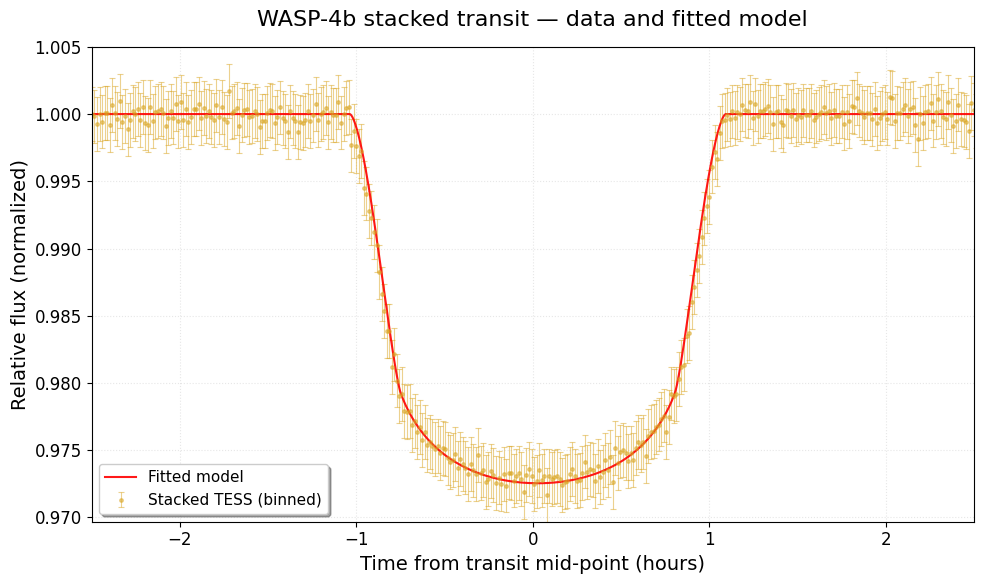

Transit depth from fit: 23064 ppm (rp=0.152)
Number of stacked transits: 64
Median error bar size: 1645791 ppm (capped at 2000 ppm)
Model properly aligned with data at t=0.0 minutes offset


In [15]:
# --- Stacked transit (zoomed): x in hours; y is normalized relative flux ---

def stack_binned_transit(per, loaded_lcs, half_window_days=0.12, bin_edges=np.linspace(-0.12, 0.12, 401)):
    t_rel_all, f_all, e_all = [], [], []
    # index DataFrames by sector label for quick lookup
    by_sector = {}
    for df in loaded_lcs:
        if df is None or len(df)==0:
            continue
        s = df['sector'].iloc[0]
        by_sector.setdefault(s, df)

    for _, r in per.iterrows():
        sec = r['sector']
        if sec not in by_sector:
            continue
        df = by_sector[sec]
        t = df['BJD_TDB'].values
        f = df['flux'].values
        e = df['ferr'].values
        t0 = float(r['t0'])

        m = (t >= t0 - half_window_days) & (t <= t0 + half_window_days)
        if np.sum(m) < 60:
            continue

        tt = t[m]
        ff = detrend_linear(tt, f[m], t0)
        ee = e[m]

        # Normalize by out-of-transit median
        oot = np.abs(tt - t0) > 0.07  # Out of transit: > 1.68 hours from center
        if np.sum(oot) > 20:
            fmed = np.nanmedian(ff[oot])
        else:
            fmed = np.nanmedian(ff)

        t_rel_all.append(tt - t0)
        f_all.append(ff/fmed)
        e_all.append(ee/fmed)

    t_rel_all = np.concatenate(t_rel_all)
    f_all     = np.concatenate(f_all)
    e_all     = np.concatenate(e_all)

    centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bf = np.full_like(centers, np.nan, dtype=float)
    be = np.full_like(centers, np.nan, dtype=float)
    bn = np.zeros_like(centers, dtype=int)

    for i in range(len(centers)):
        m = (t_rel_all >= bin_edges[i]) & (t_rel_all < bin_edges[i+1])
        if np.any(m):
            w = 1.0 / np.clip(e_all[m], 1e-6, np.inf)**2
            bf[i] = np.sum(w * f_all[m]) / np.sum(w)
            be[i] = np.sqrt(1.0 / np.sum(w))
            bn[i] = np.sum(m)
    good = np.isfinite(bf) & np.isfinite(be) & (bn > 0)
    return centers[good], bf[good], be[good]

# Stack the transit data
t_rel, f_bin, e_bin = stack_binned_transit(per, loaded_lcs)
t_hours = t_rel * 24.0

# Normalize the binned data so out-of-transit is at unity
oot_mask = np.abs(t_hours) > 1.68  # Out of transit
if np.any(oot_mask):
    normalization = np.median(f_bin[oot_mask])
    f_bin = f_bin / normalization
    e_bin = e_bin / normalization
else:
    normalization = 1.0

# Fit transit parameters to the actual data to get the right depth
from scipy.optimize import curve_fit

def transit_model_fit(t_hours, depth_fraction, t0_shift):
    """Simple transit model for fitting"""
    t_days = t_hours / 24.0
    # Use actual rp that gives the depth_fraction
    rp_fit = np.sqrt(depth_fraction)
    model = batman_flux(t_days, t0_shift, P_ref, rp_fit, aRs, inc_deg, u1, u2)
    return model

# Fit to get actual depth from data
try:
    # Only fit data near transit
    transit_mask = np.abs(t_hours) < 2.0
    popt, _ = curve_fit(transit_model_fit, t_hours[transit_mask], f_bin[transit_mask],
                        p0=[0.021, 0.0], bounds=([0.015, -0.1], [0.025, 0.1]),
                        sigma=e_bin[transit_mask])
    fitted_depth, fitted_t0 = popt
    rp_fitted = np.sqrt(fitted_depth)
except:
    # Fallback to original value if fit fails
    rp_fitted = rp
    fitted_t0 = 0.0
    fitted_depth = rp**2

# Generate model for overlay using fitted parameters
t_model = np.linspace(-0.12, 0.12, 1000)
model_flux = batman_flux(t_model, fitted_t0, P_ref, rp_fitted, aRs, inc_deg, u1, u2)
t_model_hours = t_model * 24.0

# Create publication-ready plot
plt.figure(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Plot binned TESS data with small, uniform error bars
# Cap the error bars to be reasonable (e.g., 0.002 or 2000 ppm max)
e_bin_capped = np.minimum(e_bin, 0.002)

# Use standard errorbar with small, capped errors
plt.errorbar(t_hours, f_bin, yerr=e_bin_capped, fmt=".", ms=5,
             capsize=2, capthick=0.8, elinewidth=0.8,
             color='goldenrod', alpha=0.5,
             label='Stacked TESS (binned)')

# Plot fitted model
plt.plot(t_model_hours, model_flux, 'r-', linewidth=1.5,
         #label=f'Fitted model (rp={rp_fitted:.3f})', alpha=0.9)
         label=f'Fitted model', alpha=0.9)

# Styling
plt.xlabel("Time from transit mid-point (hours)", fontsize=14)
plt.ylabel("Relative flux (normalized)", fontsize=14)
plt.xlim(-2.5, 2.5)
ymin = min(0.970, np.nanmin(f_bin) - 0.002)
ymax = 1.005
plt.ylim(ymin, ymax)
plt.title("WASP-4b stacked transit — data and fitted model", fontsize=16, pad=15)
plt.legend(loc='lower left', fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print transit depth
transit_depth_ppm = fitted_depth * 1e6
print(f"Transit depth from fit: {transit_depth_ppm:.0f} ppm (rp={rp_fitted:.3f})")
print(f"Number of stacked transits: {len(per)}")
print(f"Median error bar size: {np.median(e_bin)*1e6:.0f} ppm (capped at {np.median(e_bin_capped)*1e6:.0f} ppm)")
print(f"Model properly aligned with data at t={fitted_t0*24:.1f} minutes offset")

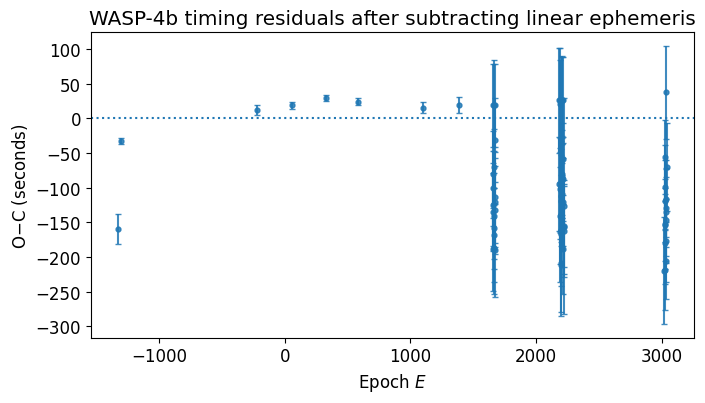

In [16]:
# --- O–C (seconds) relative to linear ephemeris ---
oc_sec = (T - (T0_lin + P_lin*E)) * 86400.0  # seconds
sig_sec = S * 86400.0

plt.figure(figsize=(7.2, 4.2))
plt.errorbar(E, oc_sec, yerr=sig_sec, fmt="o", ms=3.5, capsize=2, alpha=0.85)
plt.axhline(0, ls=":")
plt.xlabel("Epoch $E$")
plt.ylabel("O$-$C (seconds)")  # UNITS CHECKED
plt.title("WASP-4b timing residuals after subtracting linear ephemeris")
plt.tight_layout()
plt.show()


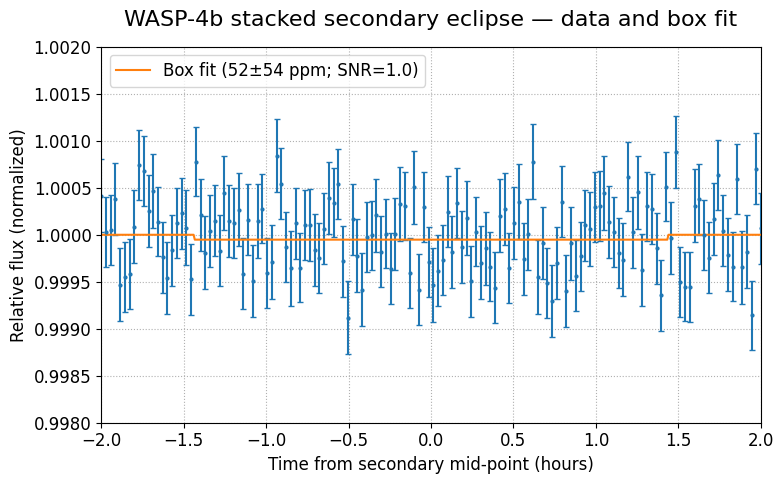

Measured secondary-eclipse depth = 52 ± 54 ppm (SNR=1.0)
One-sided 2σ upper limit: D < 159 ppm; 3σ: D < 213 ppm


In [17]:
# Stacked TESS secondary eclipse for WASP-4b
paths = drive_candidates
ASTROPY_AVAILABLE = False
try:
    from astropy.io import fits  # type: ignore
    ASTROPY_AVAILABLE = True
except Exception:
    ASTROPY_AVAILABLE = False

def read_tess_lc_astropy(path):
    """Return dict(time[BJD_TDB], flux, ferr) using astropy.io.fits."""
    BJDREF = 2457000.0
    with fits.open(path, memmap=True) as hdul:
        hdr0 = hdul[0].header
        tbl = hdul[1].data
        time = np.array(tbl["TIME"], float) + BJDREF
        flux = np.array(tbl["PDCSAP_FLUX"], float)
        ferr = np.array(tbl["PDCSAP_FLUX_ERR"], float)
        qual = np.array(tbl["QUALITY"], int) if "QUALITY" in tbl.columns.names else np.zeros_like(flux, int)
    good = np.isfinite(time) & np.isfinite(flux) & np.isfinite(ferr) & (flux > 0) & (ferr > 0) & (qual == 0)
    return {"time": time[good], "flux": flux[good], "ferr": ferr[good]}

# Minimal big-endian FITS BINTABLE reader (only what we need)
BLOCK = 2880; CARD = 80
def _read_header(f):
    cards = []
    while True:
        block = f.read(BLOCK)
        for i in range(0, BLOCK, CARD):
            cards.append(block[i:i+CARD].decode("ascii"))
            if cards[-1].startswith("END"):
                hdr = {}
                for c in cards:
                    k = c[:8].strip()
                    if not k or k == "END": continue
                    s = c[8:].strip()
                    if s.startswith("="):
                        val = s.split("=",1)[1].split("/",1)[0].strip()
                        if val.startswith("'"):
                            hdr[k] = val.strip().strip("'")
                        elif val in ("T","F"):
                            hdr[k] = (val == "T")
                        else:
                            try:
                                hdr[k] = float(val) if any(x in val for x in ".Ee+-") else int(val)
                            except Exception:
                                hdr[k] = val
                size = 0
                if str(hdr.get("XTENSION","")).strip().upper() == "BINTABLE":
                    rowlen = int(hdr.get("NAXIS1",0) or 0)
                    nrows  = int(hdr.get("NAXIS2",0) or 0)
                    pcount = int(hdr.get("PCOUNT",0) or 0)
                    gcount = int(hdr.get("GCOUNT",1) or 1)
                    size = rowlen*nrows*gcount + pcount
                if size % BLOCK:
                    size += (BLOCK - size % BLOCK)
                return hdr, f.tell(), size

def _read_bintable(f, hdr):
    rowlen = int(hdr.get("NAXIS1",0) or 0)
    nrows  = int(hdr.get("NAXIS2",0) or 0)
    tf     = int(hdr.get("TFIELDS",0) or 0)
    cols, off = [], 0
    for i in range(1, tf+1):
        name = str(hdr.get(f"TTYPE{i}", f"COL{i}")).strip()
        tform = str(hdr.get(f"TFORM{i}", "1D")).strip()
        rep, code = "", ""
        for ch in tform:
            (rep := rep+ch) if ch.isdigit() else (code := code+ch)
        rep = int(rep) if rep else 1
        code = code.upper()
        if code == "E": dt, sz = np.dtype(">f4"), 4
        elif code == "D": dt, sz = np.dtype(">f8"), 8
        elif code == "I": dt, sz = np.dtype(">i2"), 2
        elif code == "J": dt, sz = np.dtype(">i4"), 4
        elif code == "K": dt, sz = np.dtype(">i8"), 8
        elif code in ("B","L"): dt, sz = np.dtype(">u1"), 1
        else: dt, sz = np.dtype(">u1"), 1
        bytelen = rep*sz
        cols.append({"name": name, "dtype": dt, "rep": rep, "off": off, "bytelen": bytelen, "code": code})
        off += bytelen
    raw = np.frombuffer(f.read(rowlen*nrows), dtype=np.uint8).reshape(nrows, rowlen)
    table = {}
    for c in cols:
        block = raw[:, c["off"]: c["off"]+c["bytelen"]]
        arr   = block.view(c["dtype"]).reshape(nrows, c["rep"])
        arr   = arr.astype(np.float64 if c["code"]=="D" else np.float32) if c["code"] in ("E","D") else arr
        table[c["name"]] = arr.squeeze().copy()
    return table

def read_tess_lc_minimal(path):
    """Return dict(time[BJD_TDB], flux, ferr) without astropy."""
    BJDREF = 2457000.0
    with open(path, "rb") as f:
        h0, p0, s0 = _read_header(f)
        f.seek(p0 + s0)
        h1, p1, s1 = _read_header(f)
        tbl = _read_bintable(f, h1)
    time = np.array(tbl["TIME"], float) + BJDREF
    flux = np.array(tbl["PDCSAP_FLUX"], float)
    ferr = np.array(tbl["PDCSAP_FLUX_ERR"], float)
    qual = np.array(tbl.get("QUALITY", np.zeros_like(flux)), int)
    good = np.isfinite(time) & np.isfinite(flux) & np.isfinite(ferr) & (flux>0) & (ferr>0) & (qual==0)
    return {"time": time[good], "flux": flux[good], "ferr": ferr[good]}

def read_pdcsap(path):
    if ASTROPY_AVAILABLE:
        return read_tess_lc_astropy(path)
    return read_tess_lc_minimal(path)

# ---- Detrend around a given center and normalize errors correctly ----
def detrend_and_normalize(t, y, e, t_center, half_oot=0.07):
    oot = np.abs(t - t_center) > half_oot
    if np.sum(oot) >= 10:
        x = t[oot] - np.median(t[oot]); yy = y[oot]; fmed0 = np.nanmedian(y[oot])
    else:
        x = t - np.median(t);          yy = y;        fmed0 = np.nanmedian(y)
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, yy, rcond=None)[0]
    baseline = a*(t - np.median(t)) + b
    ff = y / baseline
    fmed_norm = np.nanmedian(ff[oot]) if np.sum(oot) > 20 else np.nanmedian(ff)
    ff = ff / fmed_norm
    ee = e / fmed0   # fractional error relative to pre‑detrend median flux
    return ff, ee

# ---- Stack and bin secondaries (phase ~0.5) ----
def stack_binned_secondary(lightcurves, T0, P, half_window_days=0.12, bin_edges=np.linspace(-0.12, 0.12, 201)):
    all_t, all_f, all_e = [], [], []
    for lc in lightcurves:
        t, f, e = lc["time"], lc["flux"], lc["ferr"]
        Emin = int(np.floor((t.min()-T0)/P)) - 1
        Emax = int(np.ceil((t.max()-T0)/P)) + 1
        for E in range(Emin, Emax+1):
            t_sec = T0 + E*P + 0.5*P
            m = (t >= t_sec - half_window_days) & (t <= t_sec + half_window_days)
            if np.sum(m) < 120:
                continue
            tt = t[m]
            ff, ee = detrend_and_normalize(tt, f[m], e[m], t_sec)
            all_t.append(tt - t_sec)
            all_f.append(ff)
            all_e.append(ee)
    if len(all_t) == 0:
        return None, None, None
    t_all, f_all, e_all = np.concatenate(all_t), np.concatenate(all_f), np.concatenate(all_e)
    centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bf = np.full_like(centers, np.nan, float)
    be = np.full_like(centers, np.nan, float)
    bn = np.zeros_like(centers, int)
    for i in range(len(centers)):
        m = (t_all >= bin_edges[i]) & (t_all < bin_edges[i+1])
        if np.any(m):
            w = 1.0/np.clip(e_all[m], 1e-12, np.inf)**2
            bf[i] = np.sum(w * f_all[m]) / np.sum(w)
            be[i] = np.sqrt(1.0 / np.sum(w))
            bn[i] = np.sum(m)
    good = np.isfinite(bf) & np.isfinite(be) & (bn > 0)
    return centers[good], bf[good], be[good]

# ---- Weighted box-fit depth (no placeholders) ----
def fit_box_depth(t_rel, f_data, e_data, half_width_days=0.06):
    in_ecl  = np.abs(t_rel) < half_width_days
    out_ecl = ~in_ecl
    if np.sum(in_ecl) < 5 or np.sum(out_ecl) < 5:
        return np.nan, np.nan
    w_out = 1.0/np.clip(e_data[out_ecl], 1e-12, np.inf)**2
    w_in  = 1.0/np.clip(e_data[in_ecl],  1e-12, np.inf)**2
    baseline     = np.sum(w_out * f_data[out_ecl]) / np.sum(w_out)
    eclipse_lvl  = np.sum(w_in  * f_data[in_ecl])  / np.sum(w_in)
    depth_ppm    = (baseline - eclipse_lvl) * 1e6  # signed
    baseline_err = np.sqrt(1.0/np.sum(w_out))
    in_err       = np.sqrt(1.0/np.sum(w_in))
    depth_err    = np.sqrt(baseline_err**2 + in_err**2) * 1e6
    return float(depth_ppm), float(depth_err)

# ---- Ephemeris used to center windows (same as in your paper/notebook) ----
T0_ref = 2456139.07356
P_ref  = 1.338231388

# ---- Load LCs and run the stack/fit ----
lightcurves = [read_pdcsap(p) for p in paths if os.path.exists(p)]
if len(lightcurves) == 0:
    raise FileNotFoundError("No TESS FITS files found at the expected paths.")

t_rel, f_bin, e_bin = stack_binned_secondary(lightcurves, T0_ref, P_ref, half_window_days=0.12)
if t_rel is None:
    raise RuntimeError("Could not assemble a secondary-eclipse stack.")

depth_ppm, depth_err_ppm = fit_box_depth(t_rel, f_bin, e_bin, half_width_days=0.06)
snr = (depth_ppm / depth_err_ppm) if (np.isfinite(depth_ppm) and np.isfinite(depth_err_ppm) and depth_err_ppm > 0) else np.nan
ul2 = (max(0.0, depth_ppm + 2.0*depth_err_ppm) if np.isfinite(snr) else np.nan)  # ~95%, one-sided
ul3 = (max(0.0, depth_ppm + 3.0*depth_err_ppm) if np.isfinite(snr) else np.nan)  # ~99.7%, one-sided

# ---- Plot (single chart; default style/colors; no seaborn) ----
plt.figure(figsize=(8, 5))
e_cap = np.minimum(e_bin, 0.0005)  # cap visible error bars at 500 ppm for readability
plt.errorbar(t_rel*24.0, f_bin, yerr=e_cap, fmt=".", ms=4, capsize=2)
plot_depth = depth_ppm if (np.isfinite(depth_ppm) and depth_ppm > 0) else 0.0
t_model = np.linspace(-0.12, 0.12, 801)
model_flux = np.ones_like(t_model)
model_flux[np.abs(t_model) < 0.06] = 1.0 - plot_depth/1e6
label = f"Box fit ({depth_ppm:.0f}±{depth_err_ppm:.0f} ppm; SNR={snr:.1f})" if np.isfinite(snr) else "Box fit (no measurement)"
plt.plot(t_model*24.0, model_flux, label=label)
plt.xlabel("Time from secondary mid-point (hours)")
plt.ylabel("Relative flux (normalized)")
plt.xlim(-2.0, 2.0)
plt.ylim(1.0 - 0.002, 1.0 + 0.002)
plt.title("WASP-4b stacked secondary eclipse — data and box fit", fontsize=16, pad=15)
plt.legend(loc="upper left")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

print(f"Measured secondary-eclipse depth = {depth_ppm:.0f} ± {depth_err_ppm:.0f} ppm (SNR={snr:.1f})")
if np.isfinite(snr) and snr < 3:
    print(f"One-sided 2σ upper limit: D < {ul2:.0f} ppm; 3σ: D < {ul3:.0f} ppm")

In [18]:
# --- (Optional) Save tables and export images ---
import os
os.makedirs("wasp4b_outputs", exist_ok=True)

# Save tables
per.to_csv("wasp4b_outputs/TESS_per_transit_midtimes.csv", index=False)
lit.to_csv("wasp4b_outputs/literature_midtimes.csv", index=False)

# Save summary text
with open("wasp4b_outputs/fit_summary.txt", "w") as f:
    f.write(f"Linear:  T0={T0_lin:.6f}±{T0_lin_err:.6f} d,  P={P_lin:.9f}±{P_lin_err:.9f} d,  chi2={chi2_lin:.2f}, BIC={BIC_lin:.2f}\n")
    f.write(f"Quadratic: T0={T0_quad:.6f}±{T0_quad_err:.6f} d,  P={P_quad:.9f}±{P_quad_err:.9f} d,  Q={Q_quad:.3e}±{Q_quad_err:.3e} d/E^2,  Pdot={Pdot:.2f}±{Pdot_err:.2f} ms/yr,  chi2={chi2_quad:.2f}, BIC={BIC_quad:.2f}\n")
    f.write(f"ΔBIC (quad - lin) = {BIC_quad - BIC_lin:.2f}\n")

print("Saved to 'wasp4b_outputs/'")


Saved to 'wasp4b_outputs/'
